In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
from scipy import stats
from scipy.stats import skew
from scipy.stats import kurtosis
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_transformer

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

#### Reading and Understanding the data

In [2]:
#Loading the dataframes
train = pd.read_csv('credit_risk_dataset_training.csv')
test = pd.read_csv('credit_risk_dataset_test.csv')

In [3]:
#Overview look at the training set
train.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
3,21,9900,OWN,2.0,VENTURE,A,2500,7.14,1,0.25,N,2
4,26,77100,RENT,8.0,EDUCATION,B,35000,12.42,1,0.45,N,3


In [4]:
#Overview look at the testing set
test.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,0.57,N,3,NaN
1,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,0.55,Y,4,NaN
2,24,78956,RENT,5.0,MEDICAL,B,35000,11.11,0.44,N,4,NaN
3,26,108160,RENT,4.0,EDUCATION,E,35000,18.39,0.32,N,4,NaN
4,23,92111,RENT,7.0,MEDICAL,F,35000,20.25,0.32,N,4,NaN


In [5]:
#Checking how many columns and rows are in the training dataset 
train.shape

(22850, 12)

The training set contains 22850 rows and 12 columns

In [6]:
#Checking how many columns and rows are in the training dataset 
test.shape

(9731, 12)

The testing set contains 22850 rows and 12 columns

In [7]:
#A brief look at the training set
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22850 entries, 0 to 22849
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  22850 non-null  int64  
 1   person_income               22850 non-null  int64  
 2   person_home_ownership       22850 non-null  object 
 3   person_emp_length           22237 non-null  float64
 4   loan_intent                 22850 non-null  object 
 5   loan_grade                  22850 non-null  object 
 6   loan_amnt                   22850 non-null  int64  
 7   loan_int_rate               20703 non-null  float64
 8   loan_status                 22850 non-null  int64  
 9   loan_percent_income         22850 non-null  float64
 10  cb_person_default_on_file   22850 non-null  object 
 11  cb_person_cred_hist_length  22850 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 2.1+ MB


In [8]:

train.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
count,22850.000000,2.285000e+04,22237.000000,22850.000000,20703.000000,22850.000000,22850.000000,22850.000000
mean,27.717812,6.604363e+04,4.800018,9595.500000,11.014324,0.220306,0.170243,5.801400
std,6.327822,6.423370e+04,4.112390,6327.603663,3.244035,0.414462,0.106557,4.050767
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,0.000000,2.000000
25%,23.000000,3.840000e+04,2.000000,5000.000000,7.900000,0.000000,0.090000,3.000000
50%,26.000000,5.500000e+04,4.000000,8000.000000,10.990000,0.000000,0.150000,4.000000
75%,30.000000,7.939500e+04,7.000000,12250.000000,13.470000,0.000000,0.230000,8.000000
max,144.000000,6.000000e+06,123.000000,35000.000000,23.220000,1.000000,0.780000,30.000000


In [9]:
train.describe(include=['object'])

,person_home_ownership,loan_intent,loan_grade,cb_person_default_on_file
count,22850,22850,22850,22850
unique,4,6,7,2
top,RENT,EDUCATION,A,N
freq,11506,4547,7534,18804


#### Exploratory Data Analysis

<AxesSubplot:xlabel='loan_status', ylabel='count'>

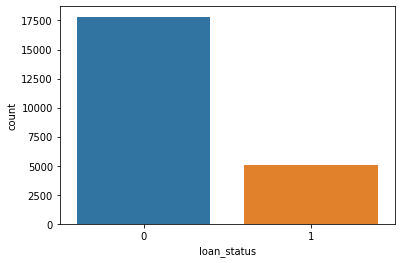

In [10]:
#Checking whether the target variable is imblanced
sns.countplot(x = train['loan_status'])

From the countplot, the target class is imbalanced with non defaulters being the majority

In [11]:
df = train.drop(columns = ['loan_status'])

In [12]:
for col in df.select_dtypes(exclude=['object']).columns:
    df[col] = df[col].replace(0,np.nan)

<AxesSubplot:>

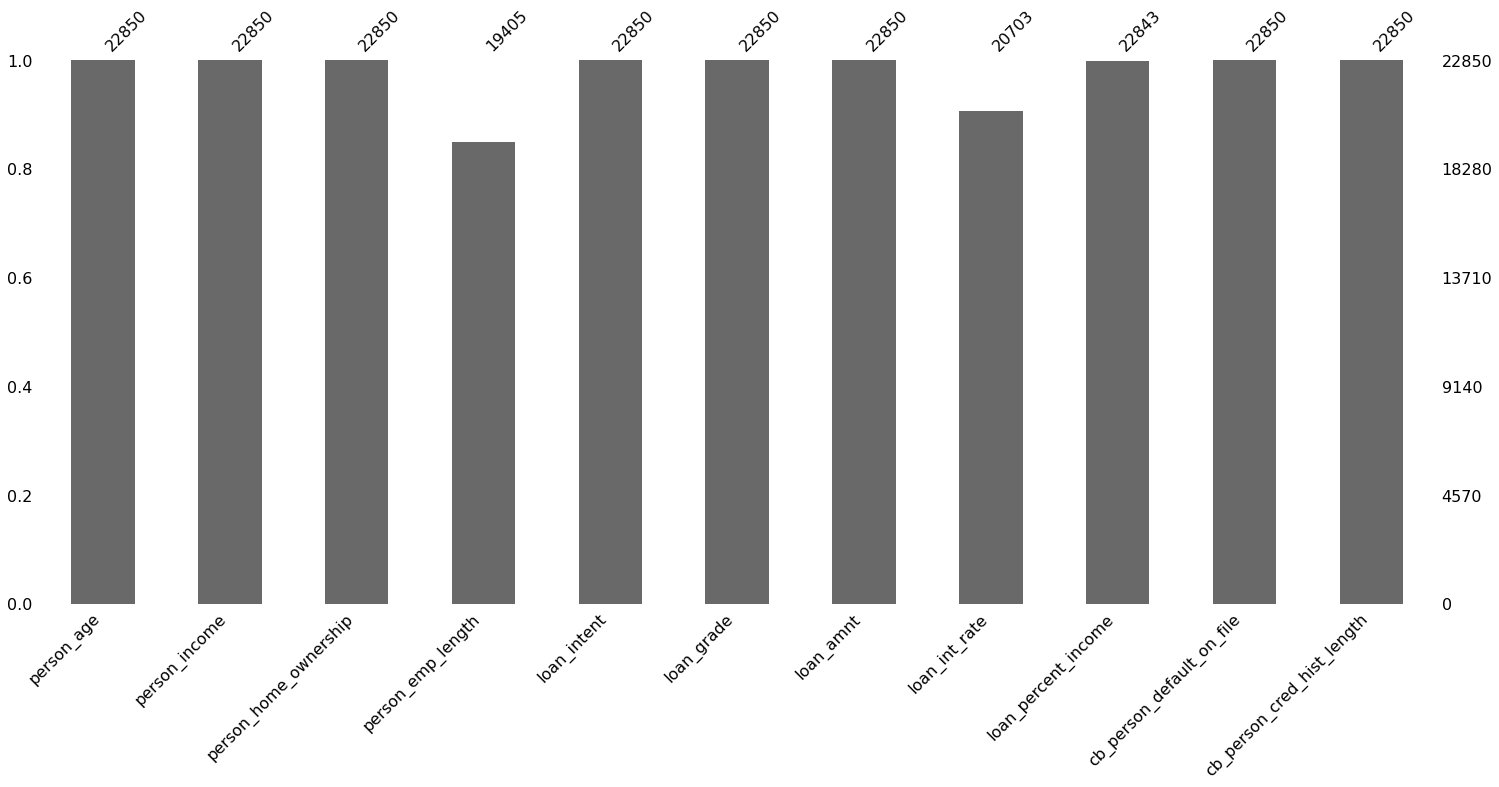

In [13]:
#Checking the missing values in our training set 
msno.bar(df)

Person_emp_length and loan_int_rate are the only columns with the missing values

<AxesSubplot:>

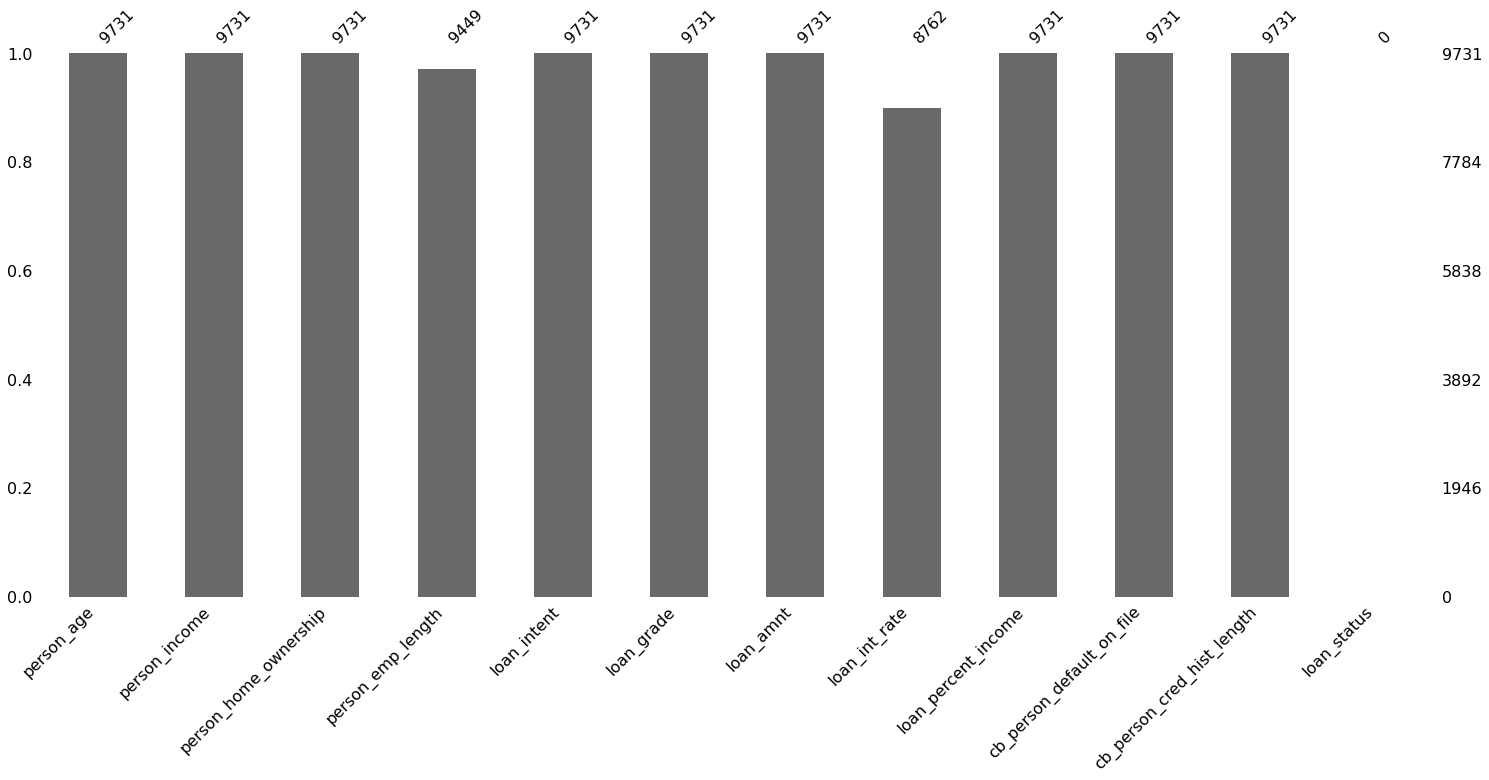

In [14]:
#Checking the missing values in our test set
msno.bar(test)

Person_emp_length and loan_int_rate are the only columns with the missing values

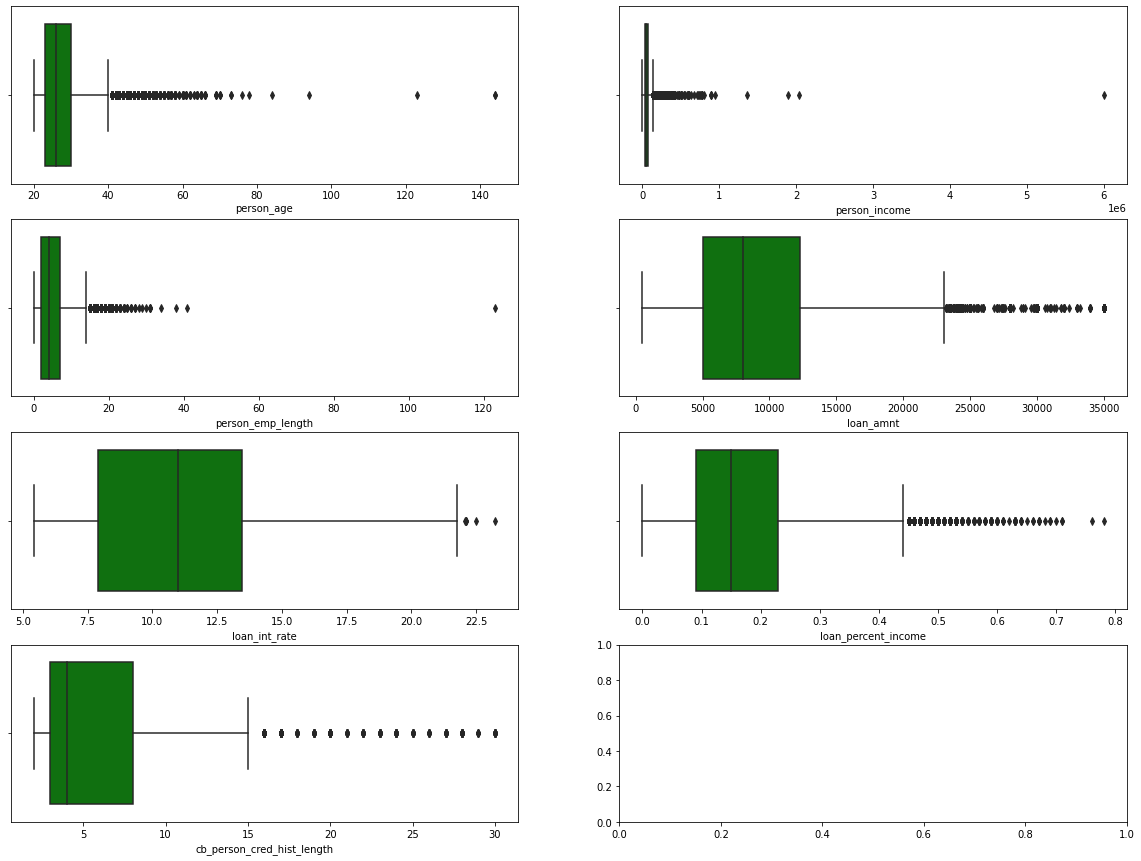

In [15]:
#Checking if numerical variables have outliers using boxplots
plt.rcParams["figure.figsize"] = (20,15)
figure, axes = plt.subplots(4,2)
cols = df.select_dtypes(exclude=['object']).columns
for col, ax in zip(list(cols), axes.flatten()):
    
    sns.boxplot(x= train[col], orient='h', ax=ax,color = 'green')
    

All the numerical variables contain outliers.By the look of the upper and lower whiskers, the position of the median, most variables seems to be right skewed.

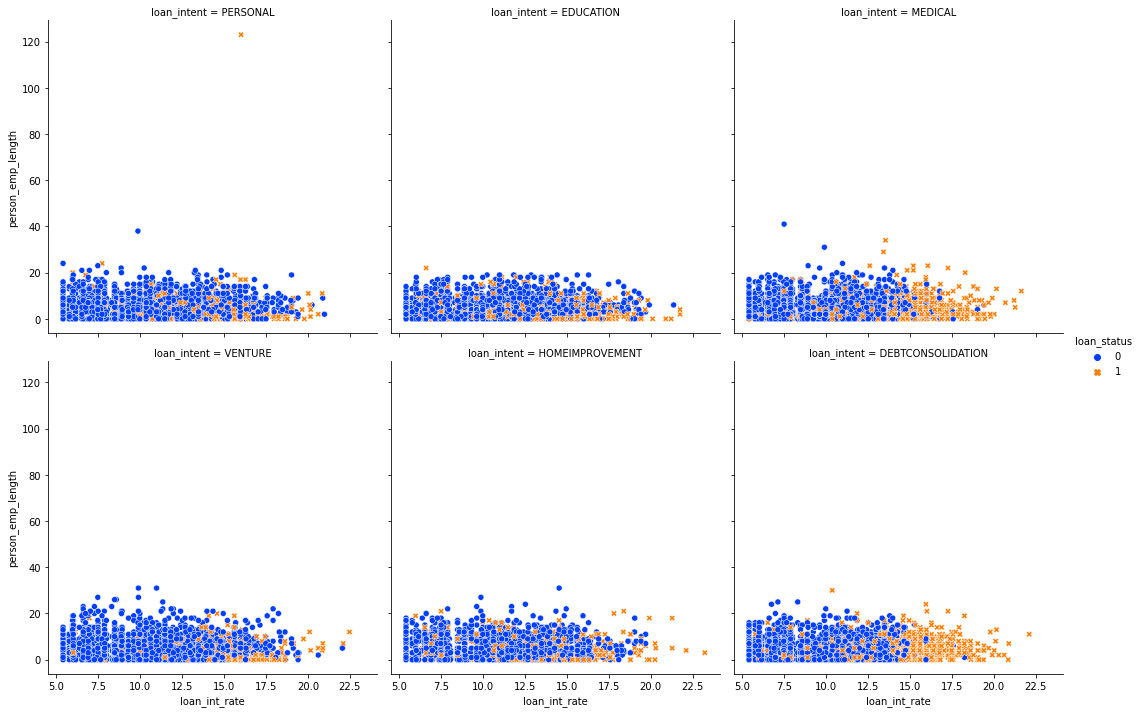

In [94]:
sns.relplot(
    data=train, kind="scatter",
    x="loan_int_rate", y="person_emp_length", hue="loan_status",style = "loan_status",
    col="loan_intent", col_wrap=3,
    height=5, aspect=1,
)
plt.savefig('Loan_intent.png')

From the plot it's clear most customers years of employment is between zero and twenty.No clear relationship between loan interest rate and number of years one has been employed.
Most customers tend to default on loans whose interest rate is high especially those whose intent is DEBTCONSOLIDATION and MEDICAL bills.

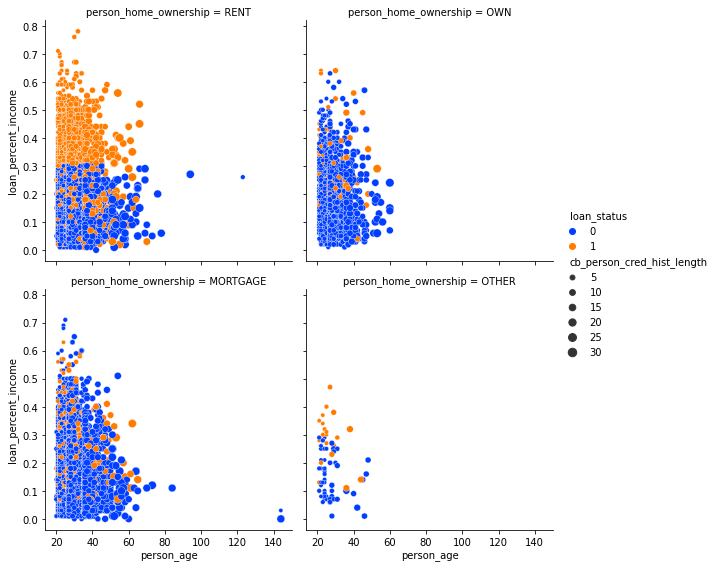

In [95]:
sns.relplot(
    data=train, kind="scatter",
    x="person_age", y="loan_percent_income", hue="loan_status",size ='cb_person_cred_hist_length',
    col="person_home_ownership", col_wrap=2,
    height=4, aspect=1,
)
plt.savefig('Home.png')

Still no clear trend between a customers age and loan percent income variable.
In all categories of home ownership, there are more loan defaulters on customers whose loan percent income is higher but more persistent on customers whose home ownership is RENT. 

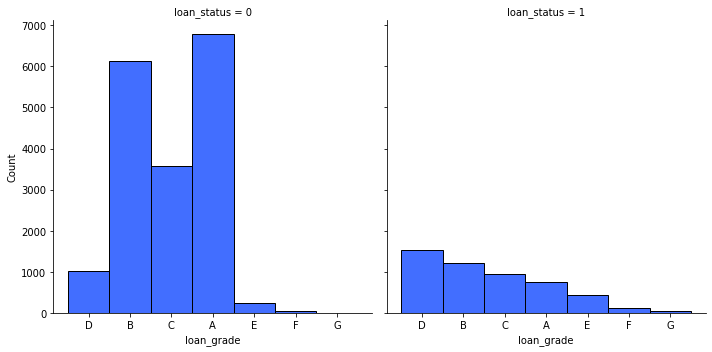

In [96]:
sns.displot(train, x="loan_grade", col="loan_status")
plt.savefig('grade.png')

People categorized as loan_grade A are the majority non-defaulters and those grouped in D more likely to default than any other group.

In [19]:
#Quantifying the skewness and kurtosis of the data
for col in cols:
    print(col)
    print('-----------------')
    print('Skewness :',train[col].skew())
    print('Kurtosis :',train[col].kurtosis())
    print('\n')

person_age
-----------------
Skewness : 2.5325011406107936
Kurtosis : 17.52417114323761


person_income
-----------------
Skewness : 39.120308803458286
Kurtosis : 3277.4938867083997


person_emp_length
-----------------
Skewness : 2.266539753030737
Kurtosis : 32.91866363629862


loan_amnt
-----------------
Skewness : 1.1915138596548815
Kurtosis : 1.417722230870548


loan_int_rate
-----------------
Skewness : 0.20303731420630727
Kurtosis : -0.672906643818151


loan_percent_income
-----------------
Skewness : 1.0533637806276215
Kurtosis : 1.1587372888875436


cb_person_cred_hist_length
-----------------
Skewness : 1.665900778232086
Kurtosis : 3.732038047444439




In [20]:
#Check if the variables contain duplicates
df.duplicated().sum()

85

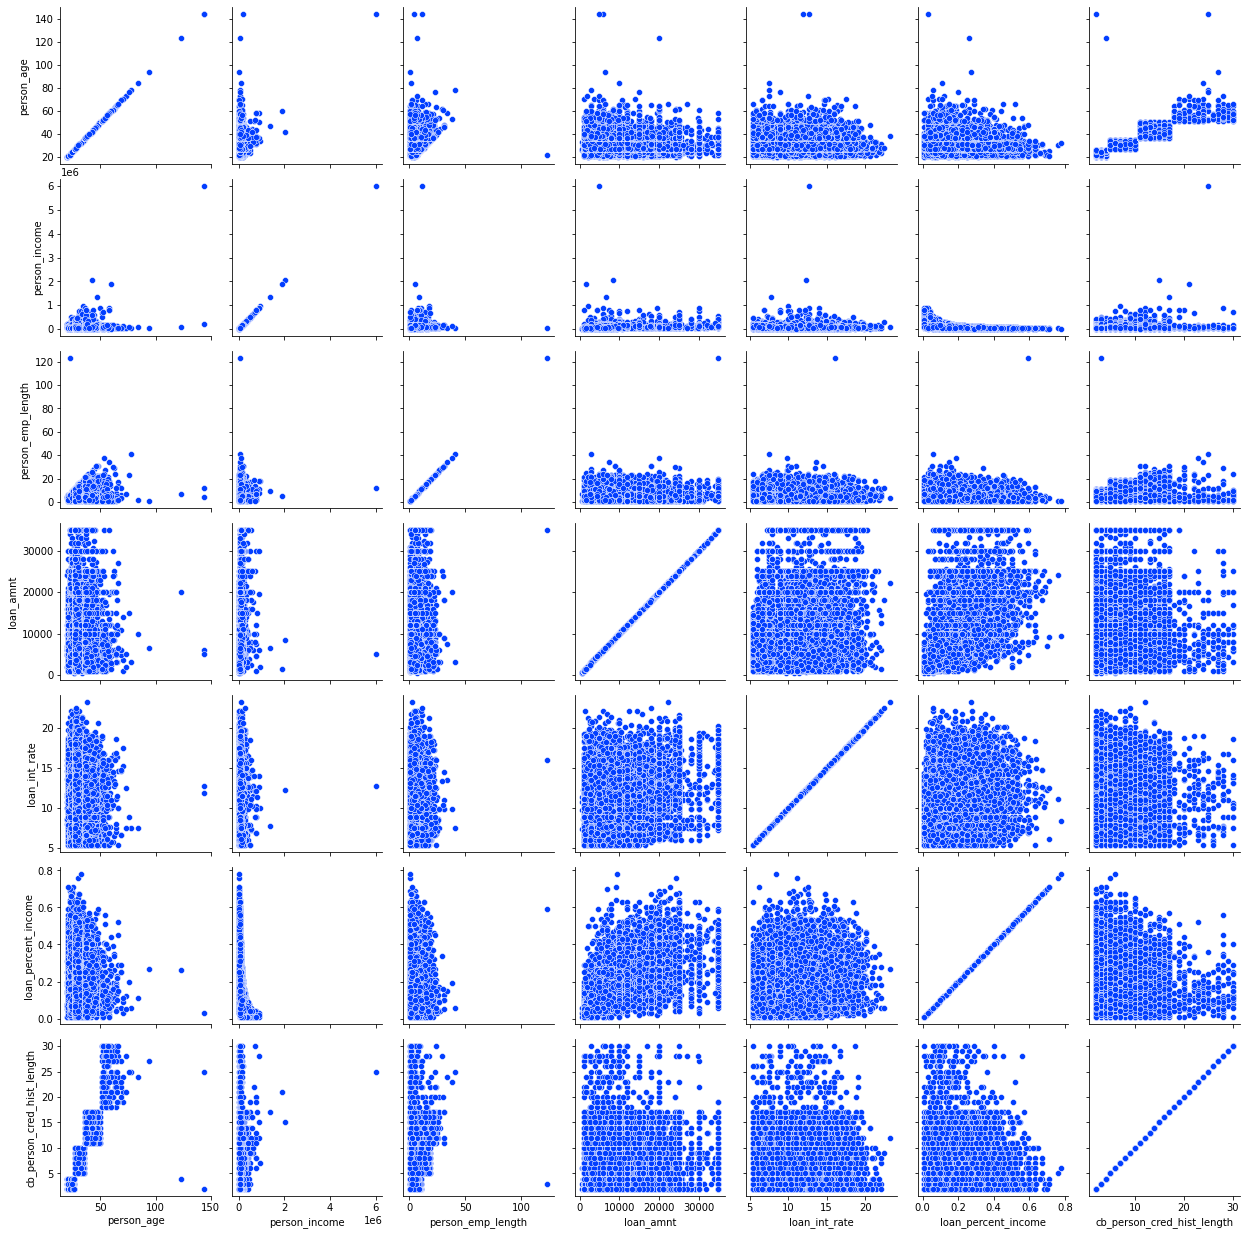

In [21]:
#Checking if there is any relationship in the numerical variables
sns.set_palette("bright")
g = sns.PairGrid(df)
g.map(sns.scatterplot)

No clear relationship between the numerical variables

In [22]:
corr = df.corr()
corr

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length
person_age,1.000000,0.184800,0.195906,0.047127,0.013473,-0.043390,0.862325
person_income,0.184800,1.000000,0.123434,0.257803,0.003142,-0.321388,0.114556
person_emp_length,0.195906,0.123434,1.000000,0.096458,-0.058623,-0.056579,0.170803
loan_amnt,0.047127,0.257803,0.096458,1.000000,0.149484,0.573424,0.040753
loan_int_rate,0.013473,0.003142,-0.058623,0.149484,1.000000,0.119464,0.019774
loan_percent_income,-0.043390,-0.321388,-0.056579,0.573424,0.119464,1.000000,-0.032725
cb_person_cred_hist_length,0.862325,0.114556,0.170803,0.040753,0.019774,-0.032725,1.000000


In [23]:
#Replacing missing values with the median
def missing_values(df):
    for col in cols:
        df[col] = df[col].fillna(df[col].median())
        
    return df.isna().sum()

In [24]:
#Handling missing values in the training set
missing_values(df) 

person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
dtype: int64

In [25]:
#Handling missing values in testing set
missing_values(test)

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length                0
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                    0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
loan_status                   9731
dtype: int64

## Data Transformation

In [26]:
#Handling outliers and skewness using boxcox transformation
def log(df):
    cols = df.select_dtypes(exclude=['object']).columns
    new_df = pd.DataFrame()
    
    for col in cols:
        new_df[col] =stats.boxcox(df[col])[0]
        
    return new_df
        
        

 

In [27]:
df1 = log(df)
df1

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length
0,0.411351,8.174213,9.140844,45.935851,6.932593,-0.487605,0.945049
1,0.411324,7.148849,1.969876,17.420331,5.281092,-1.657480,0.629748
2,0.411374,8.230077,1.648625,45.935851,6.681207,-0.577531,0.629748
3,0.411324,7.167120,0.754997,22.655589,3.682136,-1.131894,0.629748
4,0.411426,8.316572,2.706338,45.935851,5.739366,-0.709226,0.945049
...,...,...,...,...,...,...,...
22845,0.411549,8.226025,1.648625,39.720749,6.793235,-0.985872,2.002006
22846,0.411554,8.116543,0.000000,28.572250,5.995327,-1.609358,2.189208
22847,0.411551,8.547256,1.648625,38.427016,3.834922,-1.442785,2.002006
22848,0.411553,8.661435,1.969876,36.831708,5.404870,-1.657480,2.133125


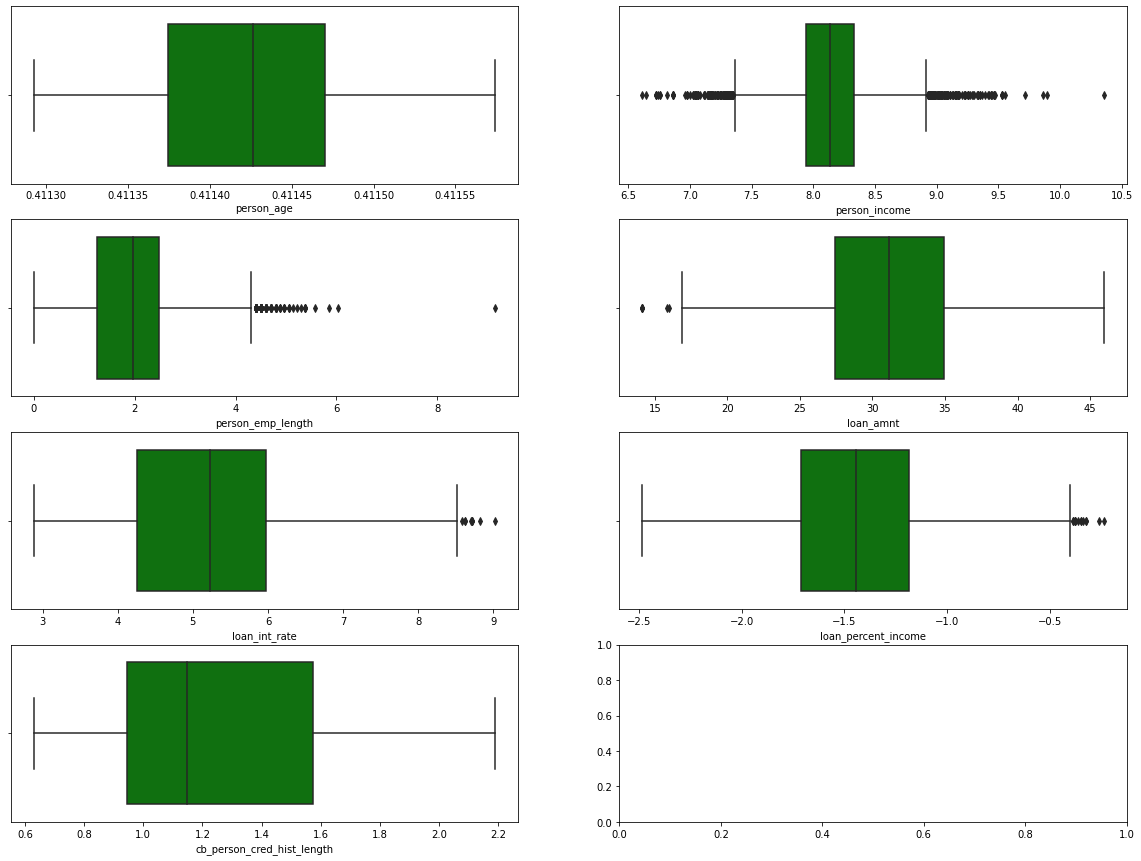

In [28]:
#Checking if numerical variables have outliers using boxplots
plt.rcParams["figure.figsize"] = (20,15)
figure, axes = plt.subplots(4,2)
cols = df.select_dtypes(exclude=['object']).columns
for col, ax in zip(list(df1.columns), axes.flatten()):
    
    sns.boxplot(x= df1[col], orient='h', ax=ax,color = 'green')

In [29]:
for col in df1.columns:
    print(col)
    print('-----------------')
    print('Skewness :',df1[col].skew())
    print('Kurtosis :',df1[col].kurtosis())
    print('\n')

person_age
-----------------
Skewness : 0.15617667967666446
Kurtosis : -0.8788771034882896


person_income
-----------------
Skewness : -0.011433511266994632
Kurtosis : 1.0409617640306577


person_emp_length
-----------------
Skewness : -0.007187768611492462
Kurtosis : 0.012520547765599854


loan_amnt
-----------------
Skewness : -0.02123439554175939
Kurtosis : -0.36897862951229143


loan_int_rate
-----------------
Skewness : -0.03805093286266846
Kurtosis : -0.6041901066984297


loan_percent_income
-----------------
Skewness : -0.026072921401855374
Kurtosis : -0.36140214868450515


cb_person_cred_hist_length
-----------------
Skewness : 0.06150138660470695
Kurtosis : -1.0399069646564558




In [30]:
#Handling the remaining outliers
cols = ['person_income','person_emp_length','loan_percent_income','loan_amnt','loan_int_rate']
for col in cols:
        q1 = df1[col].quantile(0.25)
        q3 = df1[col].quantile(0.75)
        iqr = q3-q1
        
        lower_whisker = q1 - (1.5 * iqr)
        upper_whisker = q3 + (1.5 * iqr)
        
        df1[col] = np.where((df1[col] < lower_whisker) | (df1[col]>upper_whisker),df1[col].median(),df1[col])

#### Transforming categorical columns

In [31]:
#Getting the categorical columns
cat_cols = df.select_dtypes(include=['object']).columns

In [32]:
cat_cols

Index(['person_home_ownership', 'loan_intent', 'loan_grade',
       'cb_person_default_on_file'],
      dtype='object')

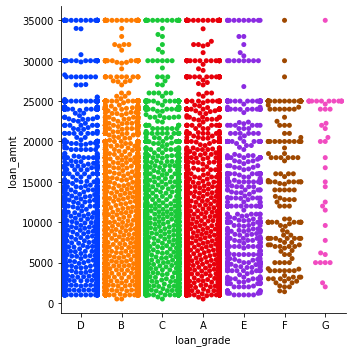

In [33]:
#Checking whether the loan_amount feature might have been used to grade the loans
sns.catplot(data=df, x="loan_grade", y="loan_amnt", kind="swarm")

From the swarmplot, loan_amnt was not used since all loan grades appear to have the same limit

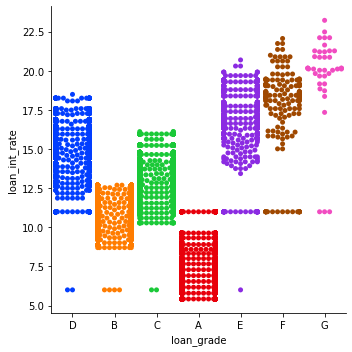

In [97]:
#Checking whether the interest_rate feature might have been used to grade the loans
sns.catplot(data=df, x="loan_grade", y="loan_int_rate", kind="swarm")

In [35]:
for col in cat_cols:
    df1[col] = df[col]

In [36]:
df1

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,person_home_ownership,loan_intent,loan_grade,cb_person_default_on_file
0,0.411351,8.174213,1.969876,45.935851,6.932593,-0.487605,0.945049,RENT,PERSONAL,D,Y
1,0.411324,8.136502,1.969876,17.420331,5.281092,-1.657480,0.629748,OWN,EDUCATION,B,N
2,0.411374,8.230077,1.648625,45.935851,6.681207,-0.577531,0.629748,RENT,MEDICAL,C,N
3,0.411324,8.136502,0.754997,22.655589,3.682136,-1.131894,0.629748,OWN,VENTURE,A,N
4,0.411426,8.316572,2.706338,45.935851,5.739366,-0.709226,0.945049,RENT,EDUCATION,B,N
...,...,...,...,...,...,...,...,...,...,...,...
22845,0.411549,8.226025,1.648625,39.720749,6.793235,-0.985872,2.002006,RENT,PERSONAL,D,Y
22846,0.411554,8.116543,0.000000,28.572250,5.995327,-1.609358,2.189208,MORTGAGE,PERSONAL,C,N
22847,0.411551,8.547256,1.648625,38.427016,3.834922,-1.442785,2.002006,MORTGAGE,PERSONAL,A,N
22848,0.411553,8.661435,1.969876,36.831708,5.404870,-1.657480,2.133125,MORTGAGE,PERSONAL,B,N


In [37]:
final_df = df1

In [38]:
final_df.shape

(22850, 11)

### Pre-Processing

In [39]:
#Categorizing features into different classes
numeric_features = list(final_df.select_dtypes(exclude=['object']).columns)
nominal_features = ['person_home_ownership','loan_intent','cb_person_default_on_file']
ordinal_features = ['loan_grade']
Y = train['loan_status']

In [40]:

ct = make_column_transformer(
      (StandardScaler(),numeric_features), #scaling numeric features
      (OneHotEncoder(),nominal_features), #transforming nominal categorical variables
      (OrdinalEncoder(), ordinal_features) # transforming ordinal categorical variables
)

In [41]:
ct

ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                 ['person_age', 'person_income',
                                  'person_emp_length', 'loan_amnt',
                                  'loan_int_rate', 'loan_percent_income',
                                  'cb_person_cred_hist_length']),
                                ('onehotencoder', OneHotEncoder(),
                                 ['person_home_ownership', 'loan_intent',
                                  'cb_person_default_on_file']),
                                ('ordinalencoder', OrdinalEncoder(),
                                 ['loan_grade'])])

In [42]:
X = ct.fit_transform(final_df)

In [43]:
ct.named_transformers_

{'standardscaler': StandardScaler(),
 'onehotencoder': OneHotEncoder(),
 'ordinalencoder': OrdinalEncoder()}

In [44]:
column_names = (
    numeric_features + 
    ct.named_transformers_['onehotencoder'].get_feature_names().tolist()+
    ordinal_features
)            

In [45]:
column_names

['person_age',
 'person_income',
 'person_emp_length',
 'loan_amnt',
 'loan_int_rate',
 'loan_percent_income',
 'cb_person_cred_hist_length',
 'x0_MORTGAGE',
 'x0_OTHER',
 'x0_OWN',
 'x0_RENT',
 'x1_DEBTCONSOLIDATION',
 'x1_EDUCATION',
 'x1_HOMEIMPROVEMENT',
 'x1_MEDICAL',
 'x1_PERSONAL',
 'x1_VENTURE',
 'x2_N',
 'x2_Y',
 'loan_grade']

In [46]:
pd.DataFrame(X,columns = column_names).head()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,x0_MORTGAGE,x0_OTHER,x0_OWN,x0_RENT,x1_DEBTCONSOLIDATION,x1_EDUCATION,x1_HOMEIMPROVEMENT,x1_MEDICAL,x1_PERSONAL,x1_VENTURE,x2_N,x2_Y,loan_grade
0,-1.336883,0.128908,0.134658,2.537288,1.544311,2.606126,-0.687417,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,3.0
1,-1.809138,-0.006695,0.134658,-2.398316,0.101834,-0.554351,-1.471747,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2,-0.932857,0.329780,-0.202257,2.537288,1.324742,2.363185,-1.471747,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0
3,-1.809138,-0.006695,-1.139456,-1.492172,-1.294749,0.865544,-1.471747,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
4,-0.020270,0.640798,0.907028,2.537288,0.502106,2.007406,-0.687417,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


In [47]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state = 42)

In [48]:
X_smote, y_smote = sm.fit_resample(X, Y)

<AxesSubplot:xlabel='loan_status', ylabel='count'>

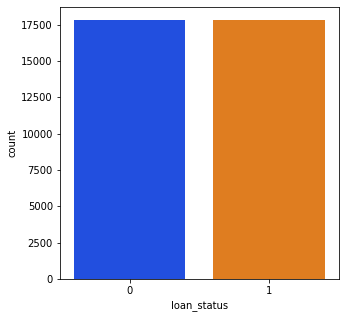

In [49]:
plt.rcParams["figure.figsize"] = (5,5)
sns.countplot(x = y_smote)

# Machine Learning

In [50]:
from sklearn.model_selection import train_test_split

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [52]:
X_res, X_res_test, y_res, y_res_test = train_test_split(X_smote, y_smote, test_size=0.2, random_state=42)

## Logistic Regression

In [53]:
#importing logistic regression model
from sklearn.linear_model import LogisticRegression

In [54]:
#Instantiating the model
lr = LogisticRegression()

In [55]:
#Training the model
lr.fit(X_res, y_res)

LogisticRegression()

In [56]:
#Predicting the outcome with unseen data
pred_lr = lr.predict(X_res_test)

#### Model Assessment

In [57]:
#Intercept
lr.intercept_[0]

-2.4546162888138516

The log_odds ratio of a particular observation being a default when other predictors are zero

In [58]:
coeff_df = pd.DataFrame(lr.coef_.T,column_names,columns=['Coefficient'])
coeff_df

,Coefficient
person_age,0.023016
person_income,0.113756
person_emp_length,0.060008
loan_amnt,-0.996571
loan_int_rate,-0.100700
loan_percent_income,1.632790
cb_person_cred_hist_length,-0.031470
x0_MORTGAGE,0.414100
x0_OTHER,0.072825
x0_OWN,-1.492031


#### Model Evaluation

In [59]:
#Confusion matrix
confusion_matrix(y_res_test, pred_lr)

array([[2756,  762],
       [ 780, 2829]], dtype=int64)

In [60]:
labels = ['0: non_default', '1: default']

pd.DataFrame(data=confusion_matrix(y_res_test, pred_lr), index=labels, columns=labels)

,0: non_default,1: default
0: non_default,2756,762
1: default,780,2829


In [61]:
print(accuracy_score(y_res_test, pred_lr)) # How often is the model correct
print(precision_score(y_res_test, pred_lr)) # When it predicts default how often is it correct
print(recall_score(y_res_test, pred_lr)) # When it's actually default how often does the model predict default

0.7836396800897993
0.7878028404344194
0.7838736492103076


In [62]:
from sklearn.metrics import classification_report

In [63]:
print('Classification Report')
print(classification_report(y_res_test, pred_lr, target_names=['0: non-default', '1: default']))

Classification Report
                precision    recall  f1-score   support

0: non-default       0.78      0.78      0.78      3518
    1: default       0.79      0.78      0.79      3609

      accuracy                           0.78      7127
     macro avg       0.78      0.78      0.78      7127
  weighted avg       0.78      0.78      0.78      7127



Recall answers the question of, when it's actually default how often does the model predict default.In this case 78 percent of the time

Precision answers the question of, when it predicts default how often is model correct.In this 78 percent of the time.

F1 score is the harmonic mean between recall and precision. In this case we use the weighted avg F1-score as the evaluation metric for the model.

Support is the number of occurrence of each class.



In [64]:
from sklearn.metrics import plot_roc_curve

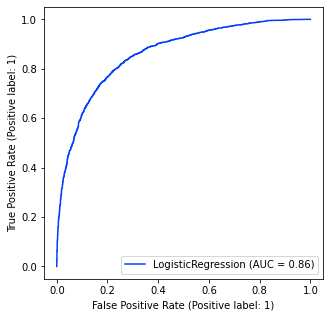

In [65]:
plot_roc_curve(lr, X_res_test, y_res_test)

Receiver Operating Characteristic(ROC) curve plots the performance of a binary classifier. Normally a trade-off between a True positive rate and False positive rate. A good classifier has a true positive rate of 100% and a false positive rate of 0%.

Area Under Curve(AUC) is the area enclosed by ROC curve.A perfect classifier has AUC = 1 and a completely random classifier has AUC = 0.5. A model will score somewhere in between. In this case the AUC score is 0.86 which is quite above a complete random classifier and almost a perfect classifier

## RandomForest

In [66]:
#importing random forest classifier
from sklearn.ensemble import RandomForestClassifier

In [67]:
#instatiating the classifier
clf = RandomForestClassifier()

In [68]:
#Training the model
clf.fit(X_res,y_res)

RandomForestClassifier()

In [69]:
#Getting feature importance in descending order
features = pd.Series(clf.feature_importances_, index=column_names).sort_values(ascending=False)
features

loan_percent_income           0.202244
loan_grade                    0.128686
loan_int_rate                 0.117909
person_income                 0.115943
loan_amnt                     0.075434
person_emp_length             0.053159
x0_RENT                       0.050108
person_age                    0.048139
cb_person_cred_hist_length    0.040841
x0_MORTGAGE                   0.030676
x1_HOMEIMPROVEMENT            0.021356
x0_OWN                        0.017532
x1_MEDICAL                    0.016967
x1_DEBTCONSOLIDATION          0.016029
x1_VENTURE                    0.014925
x1_EDUCATION                  0.014041
x2_Y                          0.012779
x2_N                          0.011674
x1_PERSONAL                   0.011038
x0_OTHER                      0.000520
dtype: float64

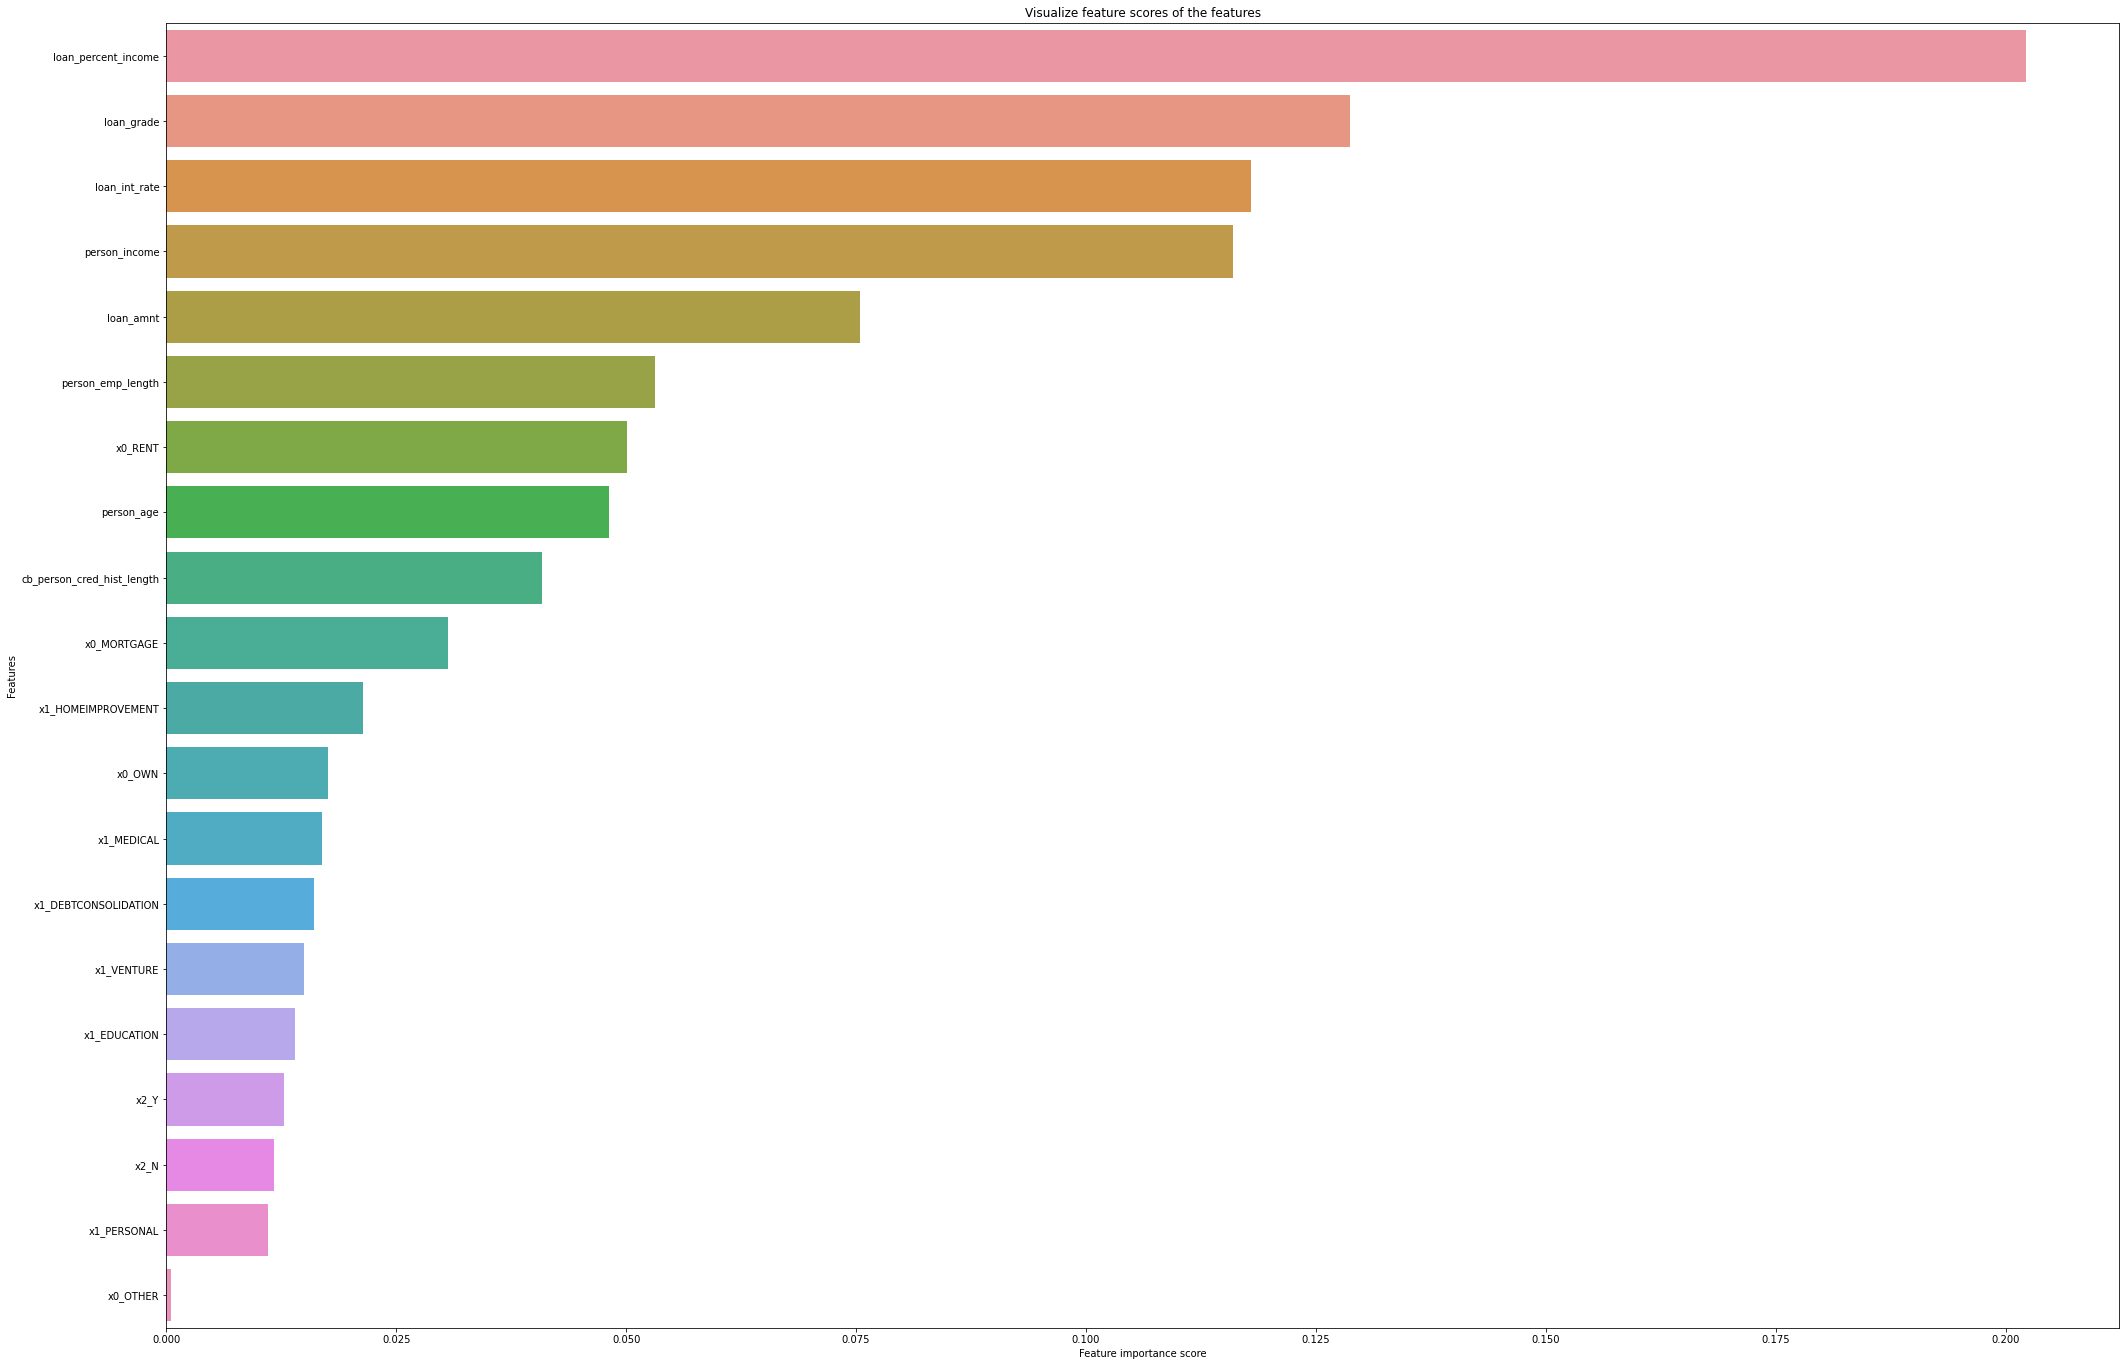

In [70]:
#plotting feature importance 
f, ax = plt.subplots(figsize=(35, 24))
ax = sns.barplot(x=features, y=features.index)
ax.set_title("Visualize feature scores of the features")
ax.set_yticklabels(features.index)
ax.set_xlabel("Feature importance score")
ax.set_ylabel("Features")
plt.show()

In [71]:
#Predicting using random forest classifier and storing the predictions in pred_clf variable
pred_clf = clf.predict(X_res_test)

In [72]:
labels = ['0: non_default', '1: default']

pd.DataFrame(data=confusion_matrix(y_res_test, pred_clf), index=labels, columns=labels)

,0: non_default,1: default
0: non_default,3433,85
1: default,346,3263


In [73]:
print(accuracy_score(y_res_test, pred_clf)) # How often is the model correct
print(precision_score(y_res_test, pred_clf)) # When it predicts default how often is it correct
print(recall_score(y_res_test, pred_clf)) # When it's actually default how often does the model predict default

0.9395257471586923
0.9746117084826762
0.9041285674702133


In [74]:
print('Classification Report')
print(classification_report(y_res_test, pred_clf, target_names=['0: non-default', '1: default']))

Classification Report
                precision    recall  f1-score   support

0: non-default       0.91      0.98      0.94      3518
    1: default       0.97      0.90      0.94      3609

      accuracy                           0.94      7127
     macro avg       0.94      0.94      0.94      7127
  weighted avg       0.94      0.94      0.94      7127



Recall answers the question of, when it's actually default how often does the model predict default.In this case 94 percent of the time

Precision answers the question of, when it predicts default how often is model correct.In this 94 percent of the time.

F1 score is the harmonic mean between recall and precision. In this case we use the weighted avg F1-score as the evaluation metric for the model.

Support is the number of occurrence of each class

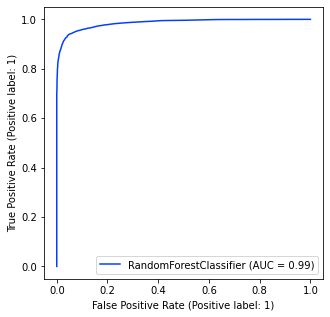

In [75]:
plot_roc_curve(clf, X_res_test, y_res_test)

Receiver Operating Characteristic(ROC) curve plots the performance of a binary classifier. Normally a trade-off between a True positive rate and False positive rate. A good classifier has a true positive rate of 100% and a false positive rate of 0%.

Area Under Curve(AUC) is the area enclosed by ROC curve.A perfect classifier has AUC = 1 and a completely random classifier has AUC = 0.5. A model will score somewhere in between. In this case the AUC score is 0.99 which is quite above a complete random classifier and almost a perfect classifier

### Naive Bayes

In [76]:
from sklearn.naive_bayes import GaussianNB

In [77]:
gnb = GaussianNB()

In [78]:
gnb.fit(X_res,y_res)

GaussianNB()

In [79]:
pred_gnb = gnb.predict(X_res_test)

In [80]:
labels = ['0: non_default', '1: default']

pd.DataFrame(data=confusion_matrix(y_res_test, pred_gnb), index=labels, columns=labels)

,0: non_default,1: default
0: non_default,2468,1050
1: default,711,2898


In [81]:
print(accuracy_score(y_res_test, pred_gnb))
print(precision_score(y_res_test, pred_gnb))
print(recall_score(y_res_test, pred_gnb))

0.7529114634488565
0.7340425531914894
0.8029925187032418


In [82]:
print('Classification Report')
print(classification_report(y_res_test, pred_gnb, target_names=['0: non-default', '1: default']))

Classification Report
                precision    recall  f1-score   support

0: non-default       0.78      0.70      0.74      3518
    1: default       0.73      0.80      0.77      3609

      accuracy                           0.75      7127
     macro avg       0.76      0.75      0.75      7127
  weighted avg       0.75      0.75      0.75      7127



# TEST DATA

In [83]:
test.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,0.57,N,3,NaN
1,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,0.55,Y,4,NaN
2,24,78956,RENT,5.0,MEDICAL,B,35000,11.11,0.44,N,4,NaN
3,26,108160,RENT,4.0,EDUCATION,E,35000,18.39,0.32,N,4,NaN
4,23,92111,RENT,7.0,MEDICAL,F,35000,20.25,0.32,N,4,NaN


In [84]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9731 entries, 0 to 9730
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  9731 non-null   int64  
 1   person_income               9731 non-null   int64  
 2   person_home_ownership       9731 non-null   object 
 3   person_emp_length           9731 non-null   float64
 4   loan_intent                 9731 non-null   object 
 5   loan_grade                  9731 non-null   object 
 6   loan_amnt                   9731 non-null   int64  
 7   loan_int_rate               9731 non-null   float64
 8   loan_percent_income         9731 non-null   float64
 9   cb_person_default_on_file   9731 non-null   object 
 10  cb_person_cred_hist_length  9731 non-null   int64  
 11  loan_status                 0 non-null      float64
dtypes: float64(4), int64(4), object(4)
memory usage: 912.4+ KB


In [85]:
data = test.drop(columns = 'loan_status')
data.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,0.57,N,3
1,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,0.55,Y,4
2,24,78956,RENT,5.0,MEDICAL,B,35000,11.11,0.44,N,4
3,26,108160,RENT,4.0,EDUCATION,E,35000,18.39,0.32,N,4
4,23,92111,RENT,7.0,MEDICAL,F,35000,20.25,0.32,N,4


In [86]:
for col in data.select_dtypes(exclude=['object']).columns:
    data[col] = df[col].replace(0,np.nan)

In [87]:
missing_values(data)

person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
dtype: int64

In [88]:
data_1 = log(data)
data_1

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length
0,0.566181,20.498476,21.430617,41.224483,6.926407,-0.483637,1.554295
1,0.565970,15.322060,2.513556,16.314814,5.277100,-1.604897,0.859189
2,0.566367,20.827163,2.028360,41.224483,6.675374,-0.571913,0.859189
3,0.565970,15.401904,0.833975,20.996147,3.679940,-1.108964,0.859189
4,0.566812,21.347131,3.738907,41.224483,5.734796,-0.700637,1.554295
...,...,...,...,...,...,...,...
9726,0.566812,22.105713,1.480176,30.152992,3.154926,-1.604897,0.859189
9727,0.566533,19.985183,0.833975,32.832081,4.804570,-1.036363,0.859189
9728,0.566533,19.985429,2.513556,32.832081,5.661104,-1.036363,1.554295
9729,0.566680,21.684693,4.433785,37.561752,7.288896,-1.036363,0.859189


In [89]:
for col in cat_cols:
    data_1[col] = data[col]

In [90]:
X_data = ct.fit_transform(data_1)

In [91]:
test['loan_status'] = clf.predict(X_data)

In [92]:
test

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,0.57,N,3,1
1,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,0.55,Y,4,0
2,24,78956,RENT,5.0,MEDICAL,B,35000,11.11,0.44,N,4,1
3,26,108160,RENT,4.0,EDUCATION,E,35000,18.39,0.32,N,4,1
4,23,92111,RENT,7.0,MEDICAL,F,35000,20.25,0.32,N,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...
9726,52,30000,RENT,6.0,VENTURE,C,5000,12.73,0.17,N,18,0
9727,60,49008,OWN,5.0,PERSONAL,C,12000,13.79,0.24,Y,21,0
9728,60,45600,RENT,1.0,VENTURE,B,20000,10.00,0.44,N,26,0
9729,52,64500,RENT,0.0,EDUCATION,B,5000,11.26,0.08,N,20,0


In [93]:
test.to_csv('submission.csv')